In [138]:
import random as rd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import expon
import math
import simpy
# import numpy.random
from collections import deque
from numpy import random

In [554]:
class TimeDependentQueue(object):
    def __init__(self,num_servers, mu, max_time):
        self.num_servers = num_servers
        self.mu = mu
        self.max_time = max_time
        self.time_steps = range(max_time)
        self.queue_length_over_time = np.zeros(max_time)
        self.num_in_queue = 0
        self.current_time = 0
        self.arrivals = []
        self.departures = []

    def time_dependent_lambda(self, t):
        half_time = self.max_time / 2
        # se está nas primeiras 1/4 de horas, lambda =1
        if t < self.max_time/4 or t > 3*self.max_time/4:
            return 1
        # se está depois lambda é uma parábola
        else:
            a = (1 - 6) / (0 - half_time)**2
            b = 0.5 - a * half_time**2

            return a * (t - half_time)**2 + b
        #return 0.5 + 0.4 * math.sin(math.pi * t / 60)
    
    def run(self):
        while self.current_time < self.max_time:
            # Determinar a próxima chegada
            lambda_current = self.time_dependent_lambda(self.current_time)
            next_arrival = self.current_time + np.random.exponential(scale=1/lambda_current)

            # Determinar a próxima saída
            if self.num_in_queue > 0:
                next_departure = self.current_time + np.random.exponential(scale=1/(self.mu * min(self.num_in_queue, self.num_servers)))
            else:
                next_departure = float('inf')

            # Atualizar o estado do sistema e registrar eventos
            if next_arrival < next_departure:
                # O próximo evento é uma chegada
                self.current_time = min(next_arrival, self.max_time)
                self.num_in_queue += 1
                self.arrivals.append(self.current_time)
            else:
                # O próximo evento é uma saída
                self.current_time = min(next_departure, self.max_time)
                self.num_in_queue = max(self.num_in_queue - 1, 0)
                if self.arrivals:
                    self.departures.append(self.current_time)

            # Registrar o comprimento da fila a cada minuto
            for t in range(int(self.current_time), self.max_time):
                self.queue_length_over_time[t] = self.num_in_queue

        plt.figure(figsize=(12,4))
        # Plotar o comprimento da fila ao longo do tempo
        plt.plot(self.time_steps, self.queue_length_over_time, label='Comprimento da Fila')
        plt.xticks(np.arange(0, self.max_time + 30, step=30))
        plt.xlabel('Tempo (minutos)')
        plt.ylabel('Comprimento da fila')
        plt.title('Simulação de Fila Dependente do Tempo (M/M/3)')
        plt.legend()
        plt.grid(True)
        plt.show()

        wait_times = [d - a for a, d in zip(self.arrivals, self.departures)]

        # Calculate mean waiting times in specified intervals
        mean_wait_0_120 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 0 <= a < 90])
        mean_wait_120_180 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 90 <= a < 270])
        mean_wait_180_300 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 270 <= a < 360])

        print(f'Tempo médio de espera em [0, 90]: {mean_wait_0_120}')
        print(f'Tempo médio de espera em [90, 270]: {mean_wait_120_180}')
        print(f'Tempo médio de espera em [270, 360]: {mean_wait_180_300}')

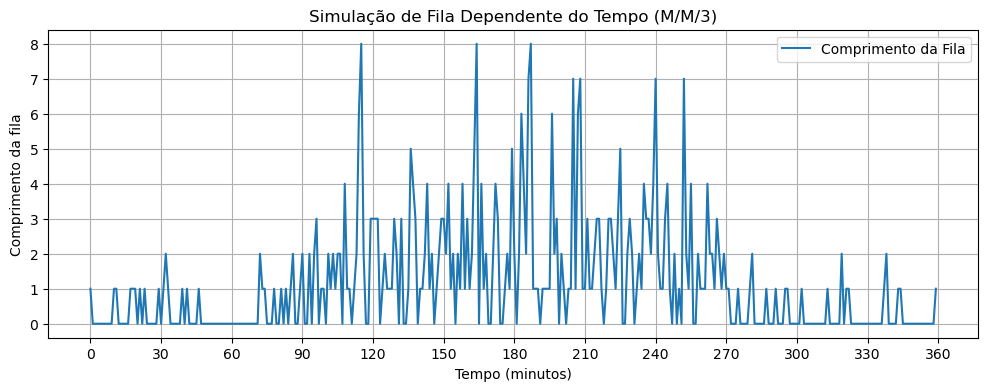

Tempo médio de espera em [0, 90]: 0.3152828704296568
Tempo médio de espera em [90, 270]: 0.412026752863903
Tempo médio de espera em [270, 360]: 0.2825687939882582


In [750]:
# Parâmetros da simulação
mu = 3.0  # taxa de serviço constante (por exemplo, 1 cliente por minuto)
servers = 3  # número de servidores
max_time = 360  # tempo total de simulação em minutos

queue = TimeDependentQueue(servers, mu, max_time)
queue.run()

### Priority Queue

In [731]:
class Mm2PriorityQueue:
    def __init__(self, high_priority_arrival_rate, low_priority_arrival_rate, service_rate, max_time):
        self.high_priority_arrival_rate = high_priority_arrival_rate
        self.low_priority_arrival_rate = low_priority_arrival_rate
        self.service_rate = service_rate
        self.max_time = max_time
        self.high_priority_queue = []
        self.low_priority_queue = []
        self.current_time = 0
        self.server_busy = [False, False]  # Two servers
        self.events = []  # List to store events for visualization

    def run(self):
        while self.current_time < self.max_time:
            # Determine the next arrival for high and low priority customers
            next_high_priority_arrival = self.current_time + expon.rvs(scale=1/self.high_priority_arrival_rate)
            next_low_priority_arrival = self.current_time + expon.rvs(scale=1/self.low_priority_arrival_rate)

            # Determine the next departure time for each server
            next_departures = [self.current_time + expon.rvs(scale=1/self.service_rate) if self.server_busy[i] else float('inf') for i in range(2)]

            # Find the next event (arrival or departure)
            next_event_time = min(next_high_priority_arrival, next_low_priority_arrival, min(next_departures))
            event_type = 'arrival' if next_event_time in [next_high_priority_arrival, next_low_priority_arrival] else 'departure'

            # Update current time
            self.current_time = next_event_time

            # Handle the event
            if event_type == 'arrival':
                if next_event_time == next_high_priority_arrival:
                    self.high_priority_queue.append(self.current_time)
                    priority = 'high'
                else:
                    self.low_priority_queue.append(self.current_time)
                    priority = 'low'
                self.events.append((self.current_time, priority, 'arrival'))
            else:
                # Find which server is departing
                departing_server = next_departures.index(next_event_time)
                self.server_busy[departing_server] = False
                self.events.append((self.current_time, 'server ' + str(departing_server), 'departure'))

            # Assign servers to waiting customers, with priority given to high priority customers
            for i in range(2):
                if not self.server_busy[i]:
                    if self.high_priority_queue:
                        self.high_priority_queue.pop(0)
                        self.server_busy[i] = True
                    elif self.low_priority_queue:
                        self.low_priority_queue.pop(0)
                        self.server_busy[i] = True

    def plot_events(self):
        times, labels, types = zip(*self.events)
        colors = {'high': 'red', 'low': 'blue', 'server 0': 'green', 'server 1': 'orange'}
        plt.scatter(times, labels, c=[colors[label] for label in labels], label=types)
        plt.xlabel('Time')
        plt.ylabel('Events')
        plt.title('M/M/2 Priority Queue Simulation')
        plt.show()

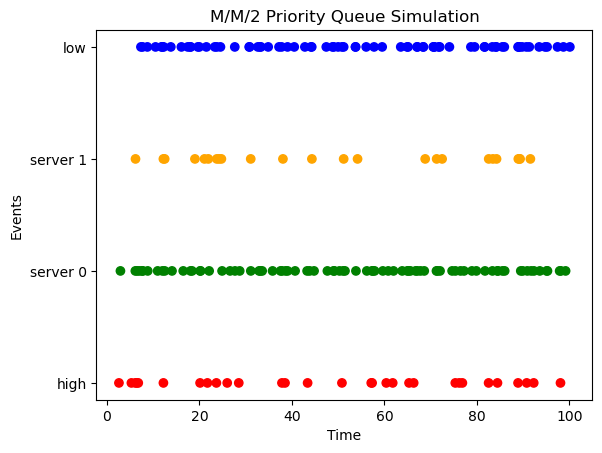

In [738]:
high_priority_arrival_rate = 0.2  # High priority customer arrival rate
low_priority_arrival_rate = 0.8   # Low priority customer arrival rate
service_rate = 3.0                # Service rate
max_time = 100                    # Simulation time

queue_sim = Mm2PriorityQueue(high_priority_arrival_rate, low_priority_arrival_rate, service_rate, max_time)
queue_sim.run()
queue_sim.plot_events()

### Retrial Queue

É quando um cliente que não foi atendido retorna para a fila. Por exemplo, um cliente que não foi atendido em um banco pode voltar para a fila no dia seguinte. Ou um cliente que não foi atendido em um call center pode ligar novamente mais tarde. Ou um cliente que não foi atendido em um site de comércio eletrônico pode voltar mais tarde para tentar novamente, etc. Quando isso acontece, dizemos que o cliente está em órbita.

- Clientes em órbita não sabem o estado das filas e apenas saberão se a fila está vazia ou não quando chegarem ao servidor. 
- Clientes entram e saem da órbita até serem atendidos ou desistirem. 

In [727]:
class RetrialQueueMM1():
    """
    Simulação de fila M/M/1 com retrials:
    Clientes chegam na fila com taxa exponencial lambda
    O tempo de serviço é exponencial com taxa mu
    Qualquer cliente ao encontrar o servidor ocupado se torna um cliente retrial (em órbita) e passa um tempo de retrial exponencial com taxa gamma até tentar novamente
    Clientes tentarão novamente até serem atendidos (caso sem desistências)
    Os interarrival times e os tempos de serviço são independentes
    """
    def __init__(self, lambda_, mu, gamma, max_time):
        self.lambda_ = lambda_
        self.mu = mu
        self.gamma = gamma
        self.max_time = max_time
        self.current_time = 0
        self.server_busy = False
        self.orbit_arrivals = []
        self.orbit_leave = []
        self.completed_customers = []
        self.arrivals = []
        self.total_orbit_time = 0
        
    def run(self):
        self.arrivals.append(np.random.exponential(1/self.lambda_))
        i = 1
        self.current_time = self.arrivals[0]
        self.end_service = self.current_time + np.random.exponential(1/self.mu)

        while self.current_time < self.max_time:
            # If server is not busy, check for arrivals or retrials
            next_arrival = self.arrivals[i-1] + np.random.exponential(1/self.lambda_)
            i += 1

            if len(self.orbit) > 0:
                retrials = [self.orbit[j] + np.random.exponential(1/self.gamma) for j in range(len(self.orbit))]
                # tempo que tentarão novamente
                next_retrial = min([j for j in retrials if j > self.end_service], default=float('inf'))
                next_retrial_index = retrials.index(next_retrial)
                next_client = min(next_arrival, next_retrial)
                if next_client == next_retrial:
                    self.orbit_times.append(next_retrial)

            else:
                next_client = next_arrival

            self.current_time = next_client   
            
            if next_client > self.end_service:
                self.server_busy = False
                retrial.append(next_client)
            else:
                self.server_busy = True
                

In [743]:
np.where(np.array([1,2,3,4,5]) > 3)[0][0]

3

In [746]:
test = [1,2,3,4,5]
min_ = min([j for j in test if j > 3], default=float('inf'))
test.index(min_)

3

In [726]:
lambda_ = 0.7
mu = 1  # taxa de serviço
gamma= 0.5
max_time = 360  # tempo total de simulação em minutos
time_steps = range(max_time)

retrial = RetrialQueueMM1(lambda_, mu, gamma, max_time=max_time)
retrial.run()

KeyboardInterrupt: 

#### Valor teórico do tempo médio em órbita

In [716]:
rho = lambda_ / mu
rho/(mu - lambda_) * (mu + gamma)/gamma

6.999999999999999